In [1]:
import optuna
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from optuna.samplers import TPESampler


import warnings
warnings.filterwarnings("ignore")


In [2]:
train_df = pd.read_parquet('data/train.parquet')
test_df = pd.read_parquet('data/test.parquet')

### Preprocessing
This preprocessing unexpectedly gives the best score.

In [5]:
train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)

In [6]:
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]

In [7]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop('total_target', axis = 1), train_df.total_target, random_state=30, test_size=0.2)

### Adding some self made "indicator" features (based on time-columns) for better business interpretability.

In [11]:

mean_opp_c_1m = train_df[train_df['total_target'] == 1]['sum_c_oper_1m'].mean()

train_df['Ind_sum_c_oper_1m'] = train_df['sum_c_oper_1m'].apply(lambda x: 1 if x < mean_opp_c_1m else 0)
test_df['Ind_sum_c_oper_1m'] = test_df['sum_c_oper_1m'].apply(lambda x: 1 if x < mean_opp_c_1m else 0)

In [12]:

mean_deb_sum_g_1m = train_df[train_df['total_target'] == 1]['sum_deb_g_oper_1m'].mean()

train_df['Ind_sum_g_oper_1m'] = train_df['sum_deb_g_oper_1m'].apply(lambda x: 1 if x < mean_deb_sum_g_1m else 0)
test_df['Ind_sum_g_oper_1m'] = test_df['sum_deb_g_oper_1m'].apply(lambda x: 1 if x < mean_deb_sum_g_1m else 0)

In [13]:

mean_deb_sum_g_1m = train_df[train_df['total_target'] == 1]['sum_deb_f_oper_1m'].mean()

train_df['Ind_sum_f_oper_1m'] = train_df['sum_deb_f_oper_1m'].apply(lambda x: 1 if x < mean_deb_sum_g_1m else 0)
test_df['Ind_sum_f_oper_1m'] = test_df['sum_deb_f_oper_1m'].apply(lambda x: 1 if x < mean_deb_sum_g_1m else 0)

In [14]:

sum_deb_sum_e_3m = train_df[train_df['total_target'] == 1]['sum_deb_e_oper_3m'].mean()
train_df['Ind_sum_e_oper_3m'] = train_df['sum_deb_e_oper_3m'].apply(lambda x: 1 if x < sum_deb_sum_e_3m else 0)
test_df['Ind_sum_e_oper_3m'] = test_df['sum_deb_e_oper_3m'].apply(lambda x: 1 if x < sum_deb_sum_e_3m else 0)

In [15]:

sum_deb_sum_g_3m = train_df[train_df['total_target'] == 1]['sum_deb_g_oper_3m'].mean()

train_df['Ind_sum_g_oper_3m'] = train_df['sum_deb_g_oper_3m'].apply(lambda x: 1 if x < sum_deb_sum_g_3m else 0)
test_df['Ind_sum_g_oper_3m'] = test_df['sum_deb_g_oper_3m'].apply(lambda x: 1 if x < sum_deb_sum_g_3m else 0)

In [16]:

cnt_c_oper_3m = train_df[train_df['total_target'] == 1]['cnt_c_oper_3m'].mean()

train_df['Ind_cnt_c_oper_3m'] = train_df['cnt_c_oper_3m'].apply(lambda x: 1 if x < cnt_c_oper_3m else 0)
test_df['Ind_cnt_c_oper_3m'] = test_df['cnt_c_oper_3m'].apply(lambda x: 1 if x < cnt_c_oper_3m else 0)

In [17]:

cnt_deb_d_oper_1m = train_df[train_df['total_target'] == 1]['cnt_deb_d_oper_1m'].mean()

train_df['Ind_cnt_d_oper_1m'] = train_df['cnt_deb_d_oper_3m'].apply(lambda x: 1 if x < cnt_deb_d_oper_1m else 0)
test_df['Ind_cnt_d_oper_1m'] = test_df['cnt_deb_d_oper_3m'].apply(lambda x: 1 if x < cnt_deb_d_oper_1m  else 0)

### NaN indicators features

In [18]:
train_df['max_end_fact_fin_deals_isna'] = train_df['max_end_fact_fin_deals'].isna()
test_df['max_end_fact_fin_deals_isna'] = test_df['max_end_fact_fin_deals'].isna()

train_df['max_end_plan_non_fin_deals_isna'] = train_df['max_end_plan_non_fin_deals'].isna()
test_df['max_end_plan_non_fin_deals_isna'] = test_df['max_end_plan_non_fin_deals'].isna()

train_df['max_start_fin_deals_isna'] = train_df['max_start_fin_deals'].isna()
test_df['max_start_fin_deals_isna'] = test_df['max_start_fin_deals'].isna()

train_df['max_start_non_fin_deals_isna'] = train_df['max_start_non_fin_deals'].isna()
test_df['max_start_non_fin_deals_isna'] = test_df['max_start_non_fin_deals'].isna()

train_df['min_end_fact_fin_deals_isna'] = train_df['min_end_fact_fin_deals'].isna()
test_df['min_end_fact_fin_deals_isna'] = test_df['min_end_fact_fin_deals'].isna()

train_df['min_end_plan_non_fin_deals_isna'] = train_df['min_end_plan_non_fin_deals'].isna()
test_df['min_end_plan_non_fin_deals_isna'] = test_df['min_end_plan_non_fin_deals'].isna()

train_df['min_start_fin_deals_isna'] = train_df['min_start_fin_deals'].isna()
test_df['min_start_fin_deals_isna'] = test_df['min_start_fin_deals'].isna()

train_df['min_start_non_fin_deals_isna'] = train_df['min_start_non_fin_deals'].isna()
test_df['min_start_non_fin_deals_isna'] = test_df['min_start_non_fin_deals'].isna()

### LGBM + Optuna

In [19]:
import lightgbm as lgb
def LightGBM(params, X_train_adv, X_valid_adv, y_train_adv, y_valid_adv):
    # Set data
    lgb_train = lgb.Dataset(X_train_adv, y_train_adv)
    lgb_valid = lgb.Dataset(X_valid_adv, y_valid_adv, reference = lgb_train)
    # Training
    model = lgb.train(
        params,
        lgb_train,
        valid_sets = [lgb_train, lgb_valid],
        num_boost_round = 3000,
    )
    # Prediction
    y_pred = model.predict(X_valid_adv, num_iteration = model.best_iteration)
    # Evaluation
    ROC_AUC_Score = roc_auc_score(y_valid_adv, y_pred)
    return ROC_AUC_Score

In [20]:
def objective(trial):
    params = {
        'task': 'train',
        'objective': 'binary',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'metric': 'AUC',
        'is_unbalance': True,
        # 'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        # 'max_bin': 255,
        'num_threads': -1,
        "bagging_freq": 1,
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_split_gain ": trial.suggest_float("min_split_gain", 0, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 0.9, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 0.9, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 800),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.95, step=0.1),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.35, 0.95, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.15, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 500),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
    }

    return LightGBM(params, X_train, X_val, y_train, y_val)

In [23]:
study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=42))
study.optimize(objective, timeout=60*60*7, show_progress_bar=True)

[I 2023-12-01 02:53:58,520] A new study created in memory with name: no-name-e5ccaf28-7849-4095-8867-357fff324488


   0%|          | 00:00/7:00:00

[I 2023-12-01 02:54:20,910] Trial 0 finished with value: 0.8881652614760613 and parameters: {'subsample': 0.8749080237694725, 'min_split_gain': 9.50714306409916, 'lambda_l1': 0.26945961053693723, 'lambda_l2': 0.1478849090084601, 'num_leaves': 128, 'feature_fraction': 0.44999999999999996, 'bagging_fraction': 0.35, 'min_child_samples': 435, 'learning_rate': 0.00025378155082656634, 'colsample_bytree': 0.7518616911266387, 'min_data_in_leaf': 20, 'n_estimators': 973, 'max_depth': 17}. Best is trial 0 with value: 0.8881652614760613.
[I 2023-12-01 02:54:39,936] Trial 1 finished with value: 0.8925054309345306 and parameters: {'subsample': 0.8424678221356553, 'min_split_gain': 1.8182496720710062, 'lambda_l1': 0.0228253207741602, 'lambda_l2': 0.039315438543298595, 'num_leaves': 422, 'feature_fraction': 0.65, 'bagging_fraction': 0.55, 'min_child_samples': 310, 'learning_rate': 3.6138942712165278e-06, 'colsample_bytree': 0.39832295125493544, 'min_data_in_leaf': 189, 'n_estimators': 510, 'max_depth

In [24]:
print('Best ROC-AUC:', study.best_value)

Best ROC-AUC: 0.9206862866670172


In [25]:
tuned_params = {**study.best_params}
tuned_params['verbose'] = -1
tuned_params['n_jobs'] = -1
tuned_params

{'subsample': 0.9395013464375127,
 'min_split_gain': 2.71667674113627,
 'lambda_l1': 0.8311103815037549,
 'lambda_l2': 0.18370169299105382,
 'num_leaves': 787,
 'feature_fraction': 0.35,
 'bagging_fraction': 0.85,
 'min_child_samples': 183,
 'learning_rate': 0.009923353855113844,
 'colsample_bytree': 0.16524743446343176,
 'min_data_in_leaf': 19,
 'n_estimators': 971,
 'max_depth': 20,
 'verbose': -1,
 'n_jobs': -1}

### Checking roc-curves and pr-curves for diffrent customer segments:

Segment: 0
ROC-AUC: 0.8992652506779749
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     34913
           1       0.73      0.33      0.45      3669

    accuracy                           0.92     38582
   macro avg       0.83      0.66      0.70     38582
weighted avg       0.91      0.92      0.91     38582

Segment: 1
ROC-AUC: 0.9198670328515901
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10521
           1       0.73      0.31      0.44       456

    accuracy                           0.97     10977
   macro avg       0.85      0.65      0.71     10977
weighted avg       0.96      0.97      0.96     10977

Segment: 2
ROC-AUC: 0.9148080085849697
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11940
           1       0.77      0.32      0.45       551

    accuracy                           0.97     12491
   macro av

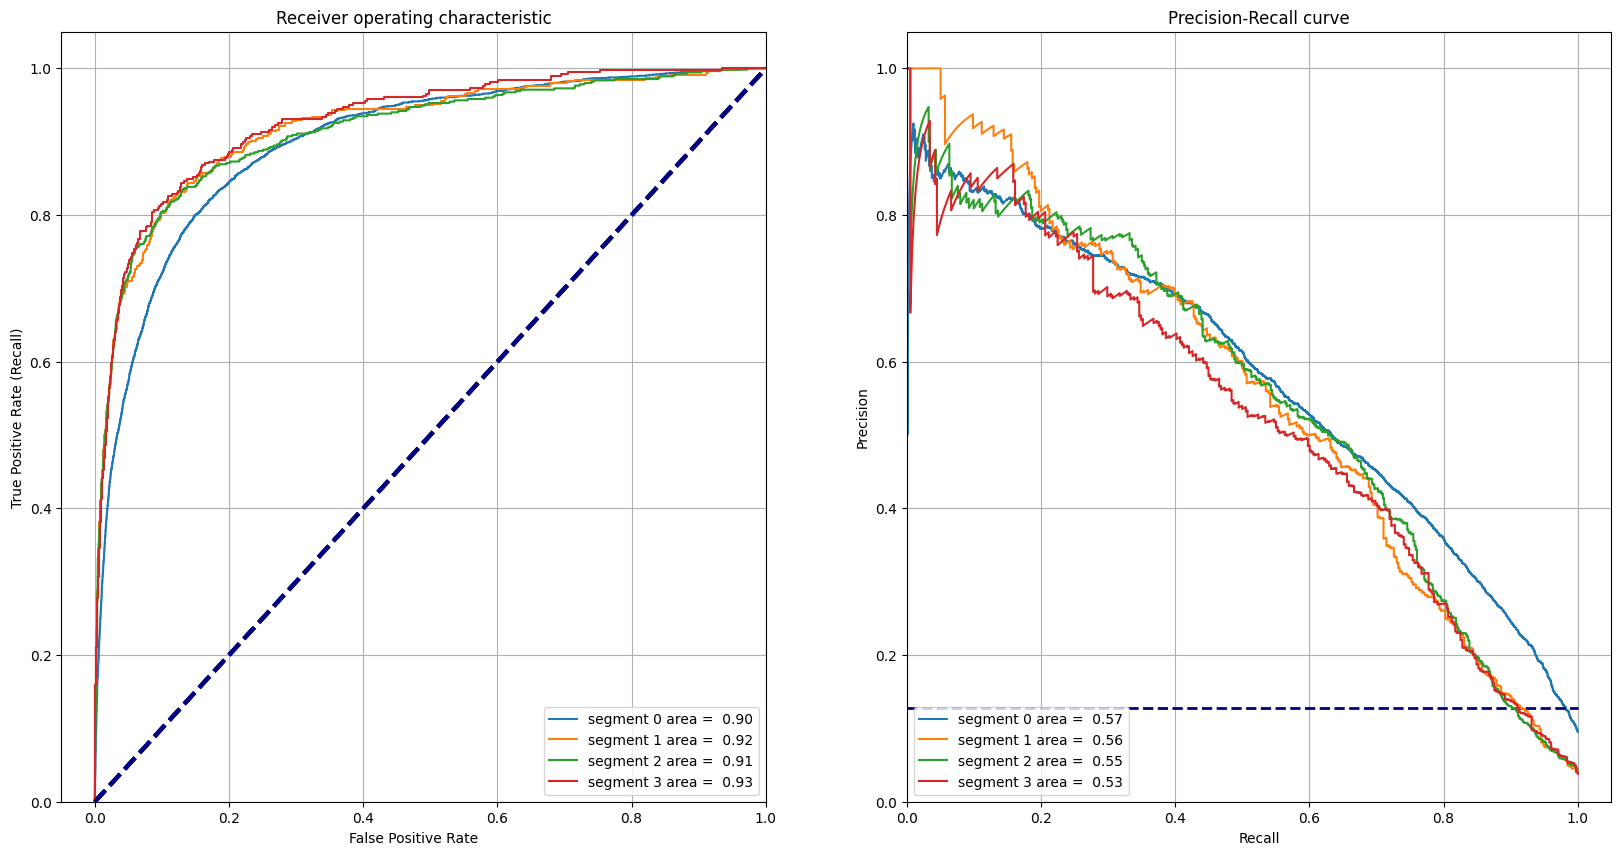

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
segments = ['0', '1', '2', '3']

model = LGBMClassifier(**tuned_params)
model.fit(X_train, y_train)

for segment in segments:
    test_data = pd.concat([X_val, y_val], axis=1)
    test_data = test_data[test_data['segment'] == segment]
    x_test_seg, y_test_seg = test_data.drop(['total_target'], axis=1), test_data['total_target'] 

    probas = model.predict_proba(x_test_seg)[:, 1]
    predicts = model.predict(x_test_seg)

    fpr, tpr, threshold = roc_curve(y_test_seg, probas)
    roc_auc = auc(fpr, tpr)


    print(f"Segment: {segment}")
    print(f"ROC-AUC: {roc_auc_score(y_test_seg, probas)}")
    print(classification_report(y_test_seg, predicts))
    
    
    show_thresholds = False
    predicted = predicts
    classes = np.unique(y_test_seg)
    predicted_prob = probas
    
    recall = metrics.recall_score(y_test_seg, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test_seg, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test_seg, predicted)  #=2 * (precision * recall) / (precision + recall)

    cm = metrics.confusion_matrix(y_test_seg, predicted, labels=classes)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_seg, predicted_prob)    
    ax[0].plot(fpr, tpr, lw=1.5, label=f'segment {segment} area = {metrics.auc(fpr, tpr): 0.2f}')
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_seg, predicted_prob)
    ax[1].plot(recalls, precisions, lw=1.5, label=f'segment {segment} area = {metrics.auc(recalls, precisions): 0.2f}')
    if segment == "0":
        ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test_seg), (cm[1,0]+cm[1,0])/len(y_test_seg)], linestyle='--', color='navy', lw=2)
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="lower left")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)


### Final: Training ensemble of LGBMs on all train_data

In [74]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
def train_ensemble(X_train, y_train, X_test, y_test=None, n_splits = 10):
    def my_cross_valid(X, y, n_splits):
        kf = KFold(n_splits=n_splits)
        models = []
        metrics = []
        X = np.array(X)
        y = np.array(y)
        pbar = tqdm(enumerate(kf.split(X)), total=n_splits)
        for i, (train_index, test_index) in pbar:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = LGBMClassifier(**tuned_params)
            model.fit(X_train, y_train)
            predicts = model.predict_proba(X_test)[:,1]
            metrics.append(roc_auc_score(y_test, predicts))
            model.booster_.save_model(f'models/lgbr_base_{i}.txt')
            models.append(model)
            pbar.set_description(f"ROC-AUC: {np.array(metrics).mean(): 0.3f} +- {np.array(metrics).std(): 0.3f}")
        return models, np.array(metrics)
    
    models, metrics = my_cross_valid(X_train, y_train, n_splits)
    print(f"Cross-validation ROC-AUC | Mean: {metrics.mean() * 100 : 0.3f}%, Standard Deviation: ({metrics.std() * 100 : 0.3f}%)")
    predicts = []
    probas = np.zeros(len(X_test))
    for model in models:
        probas += model.predict_proba(X_test)[:,1] / n_splits
        predicts.append(model.predict(X_test))

    predicts = np.round(np.sum(np.array(predicts).T, axis = 1)/n_splits)

    if y_test is not None:
        print(classification_report(y_test, predicts)) 
        print("\nROC-AUC: ", roc_auc_score(y_test, probas))
        return predicts, probas
    return probas
    

In [75]:
probas = train_ensemble(train_df.drop('total_target', axis = 1), train_df.total_target, test_df.drop('id', axis=1), n_splits=50)   

ROC-AUC:  0.916 +-  0.023: 100%|██████████| 50/50 [12:53<00:00, 15.46s/it]


Cross-validation ROC-AUC | Mean:  91.556%, Standard Deviation: ( 2.273%)


## Creating submission

In [70]:
sample_submission_df = pd.read_csv("../sample_submission.csv")
sample_submission_df["score"] = probas
sample_submission_df.to_csv("lgbm_optuna_hard_2.csv", index=False)